<a href="https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW06/HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - 生成对抗网络 (Generative Adversarial Network)**

做一个人脸识别的对抗生成网络

### 配置环境


In [2]:
# # You may replace the workspace directory if you want.
workspace_dir = '.'

# # Training progress bar
# !pip install -q qqdm

### 下载数据集

如果下载失败使用这个链接(https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [3]:
# !gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p --output "{workspace_dir}/crypko_data.zip"

# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


### 解压文件夹
解压文件后的目录结构

```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [4]:
# !unzip -q "{workspace_dir}/crypko_data.zip" -d "{workspace_dir}/"

## 随机种子

将随机种子设置为某个值以获得可重复性。

In [5]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2021)

## 导入后期需要的包

In [6]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

ImportError: No module named 'qqdm'

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [ ]:
class MyDataSet(Dataset):
    def __init__(self, root):
        names = glob.glob(os.path.join(root,"*"))
        self.names = names
        
    def __getitem__(self, index):
        file = self.names[index]
        img = torchvision.io.read_image(file)
        formatImage = transforms.Compose([
            transforms.ToPILImage(),
            # 输入图片128X128、 模型是64X64的输出、所以这里先变成64X64
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])
        return formatImage(img)

    def __len__(self):
        return len(self.names)


### 展示前16张图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


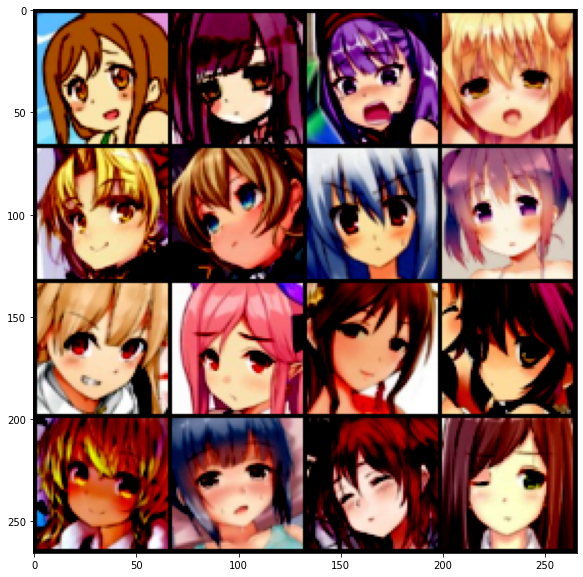

In [ ]:
dataset = MyDataSet(os.path.join(workspace_dir, 'faces'))
images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### 生成模型
使用的是DCGAN

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class Generator(nn.Module):
    def __init__(self, in_dim,out_dim=64):
        """
        Input shape: (N, in_dim)
        Output shape: (N, 3, 64, 64)
    
        """
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
          return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride =2, padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, out_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(out_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(out_dim * 8, out_dim * 4),
            dconv_bn_relu(out_dim * 4, out_dim * 2),
            dconv_bn_relu(out_dim * 2, out_dim),
            nn.ConvTranspose2d(in_channels=out_dim, out_channels =3, kernel_size=5, stride =2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self,x):
        y = self.l1(x)
        # 把数据变成指定纬度
        # import torch
        # a = torch.arange(0,20)	#此时a的shape是(1,20)
        # a.view(4,5).shape		    #输出为(4,5)
        # a.view(-1,5).shape		#输出为(4,5)
        # a.view(4,-1).shape		#输出为(4,5)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

### 判别模型
DCGAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_dim,out_dim=64):
        super(Discriminator,self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
          return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=5, stride =2, padding=2,),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
        """  WGAN需要一处最后一层的Sigmoid """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, out_dim,  kernel_size=5, stride =2, padding=2,), 
            nn.LeakyReLU(0.2),
            dconv_bn_relu(out_dim, out_dim * 2),
            dconv_bn_relu(out_dim * 2, out_dim * 4),
            dconv_bn_relu(out_dim * 4, out_dim * 8),
            nn.Conv2d(out_dim * 8, 1, 4),
            ## 比WGAN多了一个激活函数
            nn.Sigmoid(), 
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        # 把数据变成一维的
        y = y.view(-1)
        return y


### 训练预设
- 初始化数据
    - 超参数
    - 模型
    - 优化器
    - 数据加载器

In [ ]:
#超参数
batch_size = 64
z_dim = 100

# 输出预测数据用的
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

"""  WGAN中, epoch=50, n_critic=5, clip_value=0.01 """
n_epoch = 1 # 50
n_critic = 1 # 5
# clip_value = 0.01
log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)
#check device

#加载模型
G = Generator(z_dim).to(device)
D = Discriminator(3).to(device)
G.train()
D.train()

# 损失函数
criterion = nn.BCEWithLogitsLoss()

#优化器 WGAN中使用RMSprop
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

# 数据加载器
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### 开始训练
 定期存储一些图片来监控生成器的当前性能，并定期记录检查点。

In [ ]:
steps = 0
for n,epoch in enumerate(range(n_epoch)):
    for i, img in enumerate(dataloader):
        imgs = Variable(img).to(device)
        bs = imgs.size(0)

        # ============================================
        #  Train D 判别器
        # ============================================
        # torch.randn产生(0,1)正态分布的数据
        random_img = torch.randn(bs,z_dim).to(device)
        # 生成器生成一个图片
        g_img = G(random_img)

        # 判别器进行判别
        r_logit = D(imgs.detach())
        g_logit = D(g_img.detach())

        # 标签
        r_label = torch.ones(bs).to(device)
        g_label = torch.zeros(bs).to(device)

        #计算判别器的损失值
        r_loss = criterion(r_label, r_logit)
        g_loss = criterion(g_label, g_logit)
        loss_D = (r_loss + g_loss) / 2

        # 向前传播
        D.zero_grad()
        loss_D.backward()
        #更新优化器
        opt_D.step()

        # ============================================
        #  训练生成器 G
        # ============================================
        #  训练判别器n_critic次后、在训练生成器
        if steps % n_critic == 0:
            rand_img = torch.randn(bs,z_dim).to(device)
            f_img = G(rand_img)
            f_logit = D(f_img)

            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            #向前传播
            G.zero_grad()
            loss_G.backward()
            opt_G.step()
        steps +=1
        print('Epoch')
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': n+1,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, 'Epoch_{%d}jpg'.format(epoch))
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(' | Save some samples to {filename}.')

    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (n+1) % 5 == 0 or n == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))

 Iters     Elapsed Time      Speed                                              
 0/1115          -             -                                                

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

### 加载模型
生成一些图片看看

In [ ]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.cuda()

# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### 保存生成图片

In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], 'output'+(i+1)+'.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg